# Dekompozycja szeregu

W trakcie budowy modelu przeprowadza się **dekompozycje szeregu czasowego** w zależności od przyjętych założeń.

**Oznaczenia**: $m_t$ - trend, $s_t$ - sezonowość, $\varepsilon_t$ - szum.

**Model addytywny** - wielkość wahań sezonowych lub wariancja danych wokół tendencji długoterminowej (trendu) nie zmienia się wraz z poziomem szeregu:
$$y_t = m_t + s_t + \varepsilon_t$$

**Model multiplikatywny** - amplituda wahań sezonowych lub wariancja danych proporcjonalna do poziomu szeregu:
$$y_t = m_t \cdot s_t \cdot \varepsilon_t$$


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
from statsmodels.tsa.stattools import adfuller

def check_time_series_stationary(y, rolling_len=12):
    
    y = pd.Series(y)
    df_test = adfuller(y)
    
    if df_test[1] < 0.05:
        print('Szereg jest stacjonarny')
    
    else:
        print('Szereg jest niestacjonarny')
    
    print("{0:^32s}".format("Dickey-Fuller Test"))
    print("-"*32+"\n")
    
    print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
    print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
    print("-"*32+"\n")
    
    rolling_mean = y.rolling(rolling_len).mean()
    rolling_var = y.rolling(rolling_len).var()

    plt.plot(y)
    plt.plot(rolling_mean, label="Rolling mean")
    plt.plot(rolling_var, label="Rolling var")
    plt.legend()
    plt.show()
    
    print("{0:^32s}".format("Autocorrelation plot"))
    print("-"*32+"\n")
    
    pd.plotting.autocorrelation_plot(y)
    plt.show()

## Algorytm dekompozycji szeregu czasowego

1. Wyznaczamy oszacowany składnik trendu $\hat{m_t}$, wykorzystując np. metodę średniej ruchomej.
2. Oszacowany trend jest eliminowany z danych. Wyznaczamy szereg:

    a) dekompozycja addytywna: $y_t - \hat{m_t}$,
    
    b) dekompozycja multiplikatywna: $y_t/\hat{m_t}$.
    
3. Wyznaczamy indeksy sezonowe dla poszczególnych miesięcy, kwartałów, itd. Indeksy sezonowe są wyznaczane poprzez uśrednienie wartości szeregu z kroku 2 dla każdej jednostki czasu (np. miesiąc, kwartał) i wszystkich okresów (lat).
4. Standaryzujemy wskaźniki sezonowe, tak aby nie miały one wpływu na tendencję długoterminową.
5. Wyznaczamy reszty, usuwając trend i sezonowość

    a) dekompozycja addytywna: $\varepsilon_t = y_t - \hat{m_t} - \hat{s_t}$,
    
    b) dekompozycja multiplikatywna: $\varepsilon_t = y_t/\hat{m_t}/\hat{s_t}$.


Chcemy dekomponować szereg, ponieważ łatwiej jest modelować poszczególne części:
- trend z regrsją liniową czy wielomianową
- sezonowość - powtarzanie dla konkretnych miesięcy średnich wyliczonych na danych uczących pozbawionych trendu
- losowość reszt - jeśli stacjonarna to używamy np. ARMA

## ***Zadanie 1

a) Przy użyciu metody średniej ruchomej oszacuj trend dla szeregu `southern`, wiedząc, że dla szeregu długości $n$, tzn. $Y_1, \ldots, Y_n$ estymacja średniej ruchomej w chwili $t$ jest postaci:
$$m(t)=\frac{1}{2q+1}\sum_{i=-q}^qY_{t-i},$$
gdzie $q$ jest rzędem średniej ruchomej (np. `convolution_filter` z `statsmodels.tsa.filters.filtertools`). 

Innymi słowy, aby wyznaczyć oszacowaną wartość trendu w chwili $t$, uśredniamy $q$ poprzedzających ten moment wartości i $q$ wartości następujących po tym momencie.

b) Następnie wyznacz indeksy sezonowe dla mięsięc, a potem wystandaryzuj je przez średnią.

c) Oszacuj wartość reszt szeregu, sprawdź jego stacjonarność.

Załóż, że szereg `southern` jest szeregiem addytywnym.

In [3]:
southern = pd.read_csv('../data/southern.csv', parse_dates=['Date'], index_col='Date')
southern

,Southern
Date,
1955-01-01,-0.7
1955-02-01,1.3
1955-03-01,0.1
1955-04-01,-0.9
1955-05-01,0.8
...,...
1992-08-01,0.0
1992-09-01,0.0
1992-10-01,-1.9


<AxesSubplot:xlabel='Date'>

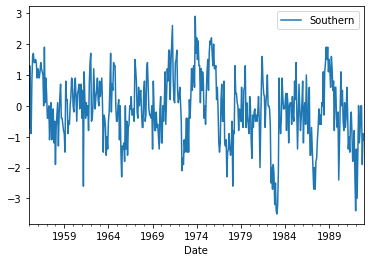

In [4]:
southern.plot()

#### Oszacowanie trendu
używamy metody `convolution_filter`:
jeśli `n_sizes = 2`  to sumujemy wszystkie elmenty odległe o `freq/2` z dwóch stron od zadanego punktu i tak przechodzimy punkt po punkcie (innymi słowy: robimy sumę ruchomą)

In [5]:
from statsmodels.tsa.filters.filtertools import convolution_filter

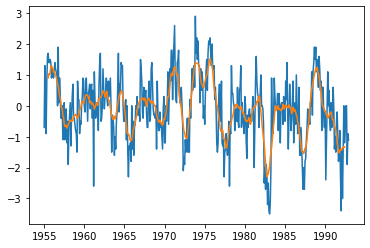

In [12]:
# średnia ruchoma
period = 12
trend = convolution_filter(southern.Southern, np.ones(period + 1), nsides=2) / (period + 1)

# wykres średniej ruchomej
plt.plot(southern)
plt.plot(trend)

#### Oszacowanie sezonowości

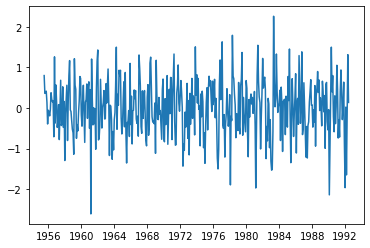

In [13]:
# wyrzucamy trend

detrended = southern.Southern - trend
plt.plot(detrended)
plt.show()

In [14]:
# liczymy na szeregu bez trendu średnie dla poszczególnych miesięcy

month_avgs = np.array([np.nanmean(detrended[i::period], axis=0) for i in range(period)])
print(month_avgs)

month_avgs -= np.mean(month_avgs, axis=0)
print(np.mean(month_avgs, axis=0))

[-0.02702703 -0.07920998 -0.1966736   0.06382536  0.18232848 -0.08523909
  0.05218295  0.00561331  0.10914761  0.03430353 -0.01101871 -0.03950104]
-5.782411586589357e-19


In [15]:
# powtarzamy średnie tyle razy ile mamy lat, w efekcie mamy szereg długości southern, 
# gdzie dla każdego miesiąca w każdym roku, mamy średnią wyliczoną dla danego miesiąca 

seasonal = np.tile(month_avgs.T, southern.size // period).T
seasonal = pd.Series(seasonal, index=southern.index)

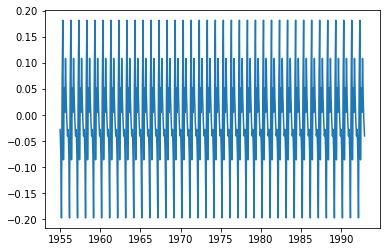

In [17]:
plt.plot(seasonal)
plt.show()

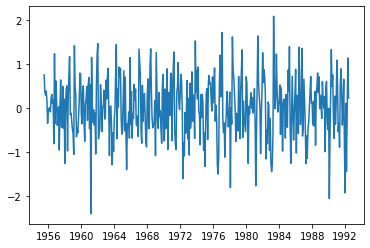

In [18]:
# rozpatrujemy część losową - bez średniej i bez trendu

resid = detrended - seasonal
plt.plot(resid)
plt.show()

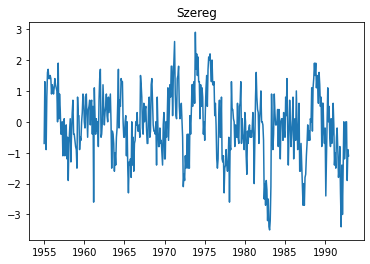

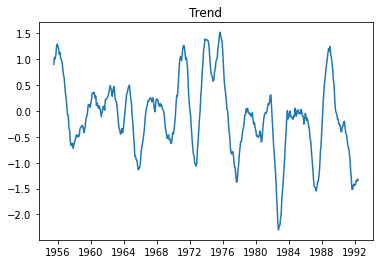

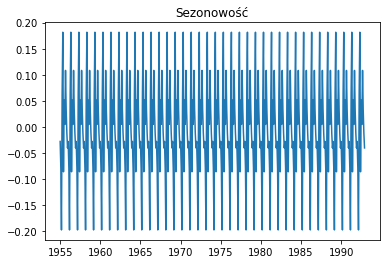

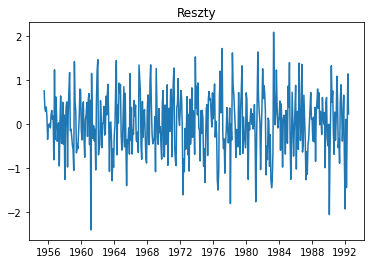

In [22]:
plt.plot(southern)
plt.title('Szereg')
plt.show()

plt.plot(trend)
plt.title('Trend')
plt.show()

plt.plot(seasonal)
plt.title('Sezonowość')
plt.show()

plt.plot(resid)
plt.title('Reszty')
plt.show()

#### Oszacowanie elementu losowego i diagnostyka stacjonarności

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -7.9729
p-value             :     0.0000
--------------------------------



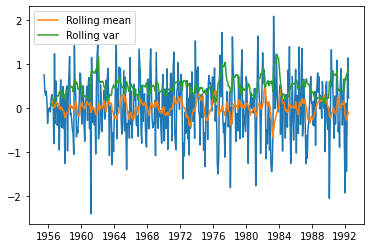

      Autocorrelation plot      
--------------------------------



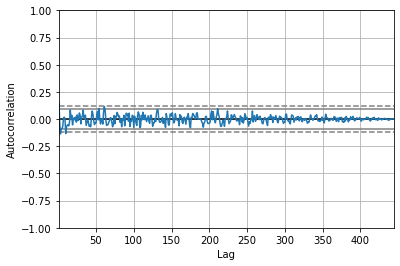

In [20]:
check_time_series_stationary(resid.dropna())

## Zadanie 2
Dokonaj dekompozycji szeregu przy użyciu `seasonal_decompose` dla następujących danych:
- `southern`,
- `a10`,
- `AirPassengers`, 
- `sunspots`.

### `southern`

In [34]:
southern = pd.read_csv('../data/southern.csv', parse_dates=['Date'], index_col='Date')
southern

,Southern
Date,
1955-01-01,-0.7
1955-02-01,1.3
1955-03-01,0.1
1955-04-01,-0.9
1955-05-01,0.8
...,...
1992-08-01,0.0
1992-09-01,0.0
1992-10-01,-1.9


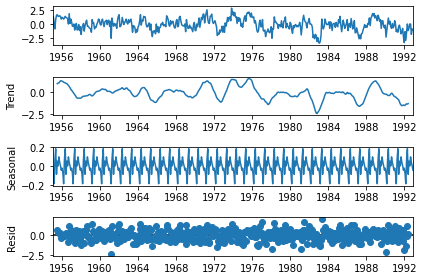

In [35]:
southern_dec = seasonal_decompose(southern, model = 'additive')

southern_dec.plot()
plt.show()

In [36]:
print(southern_dec.trend[:12])
print(southern_dec.seasonal)
print(southern_dec.resid[0:12])

Date
1955-01-01         NaN
1955-02-01         NaN
1955-03-01         NaN
1955-04-01         NaN
1955-05-01         NaN
1955-06-01         NaN
1955-07-01    0.954167
1955-08-01    1.025000
1955-09-01    1.050000
1955-10-01    1.166667
1955-11-01    1.275000
1955-12-01    1.283333
Name: trend, dtype: float64
Date
1955-01-01   -0.024287
1955-02-01   -0.079354
1955-03-01   -0.189715
1955-04-01    0.064339
1955-05-01    0.181569
                ...   
1992-08-01   -0.000413
1992-09-01    0.095308
1992-10-01    0.037200
1992-11-01    0.000826
1992-12-01   -0.046471
Name: seasonal, Length: 456, dtype: float64
Date
1955-01-01         NaN
1955-02-01         NaN
1955-03-01         NaN
1955-04-01         NaN
1955-05-01         NaN
1955-06-01         NaN
1955-07-01    0.695571
1955-08-01    0.375413
1955-09-01    0.254692
1955-10-01    0.296134
1955-11-01    0.124174
1955-12-01   -0.336862
Name: resid, dtype: float64


### `a10`

In [37]:
a10 = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')
a10.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


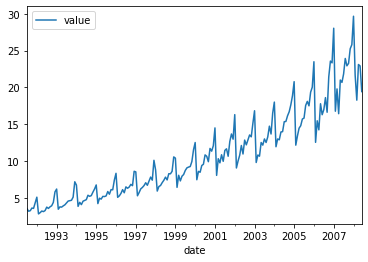

In [43]:
a10.plot()
plt.show()

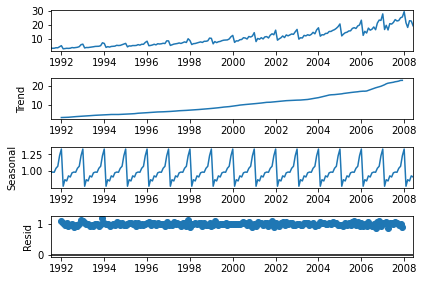

In [39]:
a10_dec = seasonal_decompose(a10, model = 'multiplicative')
a10_dec.plot()
plt.show()

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -5.9908
p-value             :     0.0000
--------------------------------



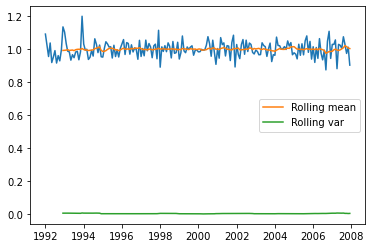

      Autocorrelation plot      
--------------------------------



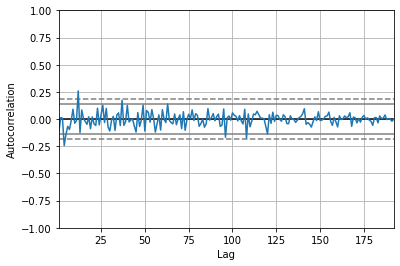

In [40]:
check_time_series_stationary(a10_dec.resid.dropna())

### `AirPassengers`

In [41]:
air_passengers = pd.read_csv('../data/AirPassengers.csv', parse_dates=['Month'], index_col='Month')
air_passengers.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


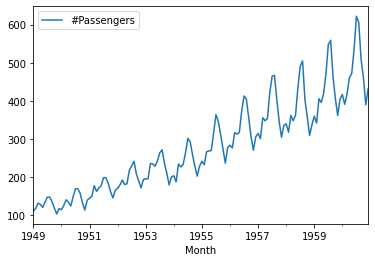

In [44]:
air_passengers.plot()
plt.show()

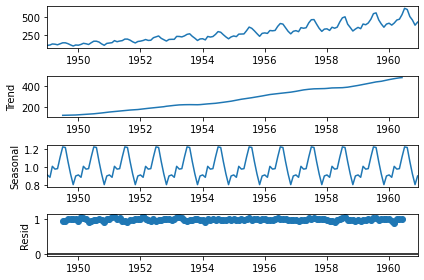

In [59]:
air_passengers_dec = seasonal_decompose(air_passengers, model = 'multiplicative', period=12)
air_passengers_dec.plot()
plt.show()

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -7.4159
p-value             :     0.0000
--------------------------------



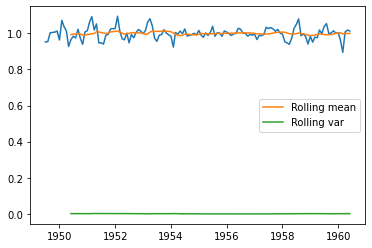

      Autocorrelation plot      
--------------------------------



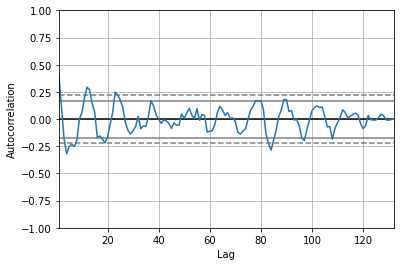

In [60]:
check_time_series_stationary(air_passengers_dec.resid.dropna())

### `sunspot` 
Time Series:
Start = 1700 
End = 1988 
Frequency = 1 

In [47]:
sunspot = pd.read_csv('../data/sunspot.csv')
sunspot

,value
0,5.0
1,11.0
2,16.0
3,23.0
4,36.0
...,...
284,45.9
285,17.9
286,13.4
287,29.2


In [62]:
sunspot.index = pd.date_range('1700', '1988', freq = 'AS')  # nadajemy rok jako indeks dla poszczególnych obserwacji
sunspot.index

DatetimeIndex(['1700-01-01', '1701-01-01', '1702-01-01', '1703-01-01',
               '1704-01-01', '1705-01-01', '1706-01-01', '1707-01-01',
               '1708-01-01', '1709-01-01',
               ...
               '1979-01-01', '1980-01-01', '1981-01-01', '1982-01-01',
               '1983-01-01', '1984-01-01', '1985-01-01', '1986-01-01',
               '1987-01-01', '1988-01-01'],
              dtype='datetime64[ns]', length=289, freq='AS-JAN')

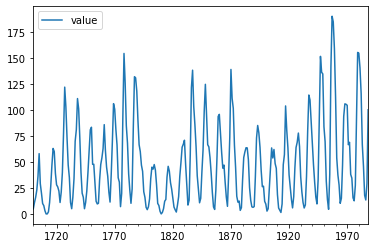

In [63]:
sunspot.plot()
plt.show()

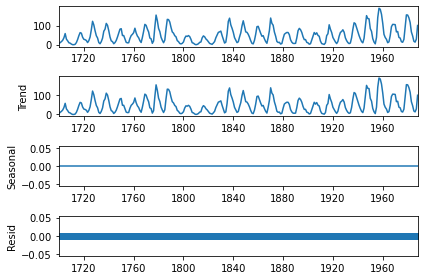

In [70]:
sunspot_dec = seasonal_decompose(sunspot, model = 'additive')

sunspot_dec.plot()  # nie znajdujemy żadnej sezonowości, gdyż domyślnie period=1 (zatem reszty są zerowe!)
plt.show()

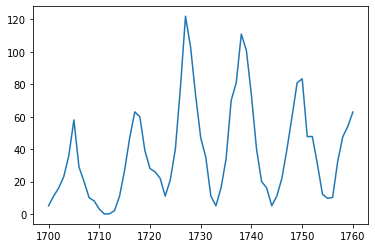

In [71]:
plt.plot(sunspot[(sunspot.index >= '1700') & (sunspot.index <= '1760')])
plt.show()

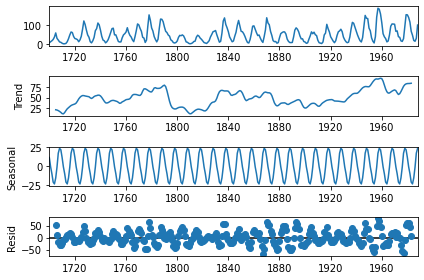

In [72]:
sunspot_dec = seasonal_decompose(sunspot, model = 'additive', period=10)

sunspot_dec.plot()
plt.show()

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -9.7682
p-value             :     0.0000
--------------------------------



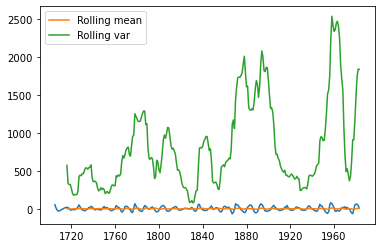

      Autocorrelation plot      
--------------------------------



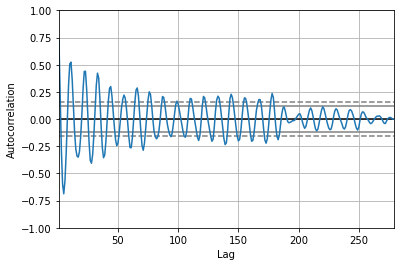

In [73]:
check_time_series_stationary(sunspot_dec.resid.dropna())  # nie jesteśmy w stanie usunąć całej sezonowości !!

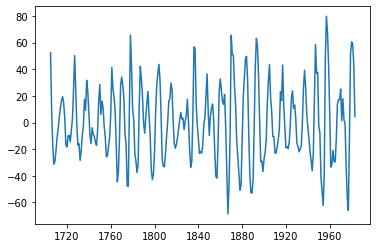

In [74]:
plt.plot(sunspot_dec.resid.dropna())  # metoda dekompozycji szeregu nie działa (metoda przekształceń również zawodzi ...)